# Austria

In [17]:
from io import StringIO
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

%config InlineBackend.figure_format = 'retina'

## Fetch results

In [18]:
def get_links_by_letter(letter):
    base_url = 'https://bundeswahlen.gv.at/2019_2'
    url = f'{base_url}/gemeinden-{letter}.html'
    r = requests.get(url)
    html = BeautifulSoup(r.text)
    lis = html.select_one('.gmd-list').select('.nav-link')
    return [f"{base_url}/{x['href']}" for x in lis]

In [19]:
def get_vienna():
    """Special case for Vienna."""
    base_url = 'https://bundeswahlen.gv.at/2019_2'
    r = requests.get(f'{base_url}/9.html')
    html = BeautifulSoup(r.text)
    select = html.select_one('#qsbz')
    ids = [f"{base_url}/{x.attrs['value']}.html" for x in select.select('option')]
    return ids[1:]

In [20]:
def get_breadcrumbs(text):
    html = BeautifulSoup(text)
    crumbs = html.select_one('.breadcrumbs')
    crumbs = crumbs.select('span')
    return [x.text for x in crumbs]

In [21]:
def get_turnout(text):
    table = pd.read_html(StringIO(text), header=1, index_col=0, decimal=',')[0]
    turnout = table.loc['Abgegebene', '%']
    return turnout.split('\xa0')[0]

In [22]:
def get_municipality(url):
    r = requests.get(url)
    r.encoding = 'utf-8'
    crumbs = get_breadcrumbs(r.text)
    turnout = get_turnout(r.text)
    return (crumbs, turnout, url)

In [23]:
def run():
    letters = 'abdefghijklmnoprstuvwyz'
    links = []
    data = []
    for letter in letters:
        links.extend(get_links_by_letter(letter))
    links.extend(get_vienna())
    for link in links:
        try:
            data.append(get_municipality(link))
        except requests.exceptions.InvalidSchema:
            print(link)
    return data

In [24]:
def create_frame():
    results = run()
    df = pd.DataFrame(results, columns=['crumbs', 'turnout', 'url'])
    df['turnout'] = df['turnout'].str.replace(',', '.').astype(float)
    df['id'] = df.url.str.split('at\/', expand=True)[1].str.split('\.', expand=True)[0]
    return df

In [25]:
%%time
df = create_frame()

CPU times: user 1min 28s, sys: 2.86 s, total: 1min 30s
Wall time: 7min 26s


In [28]:
df['id'] = df['id'].str.split('/', expand=True)[1]

In [29]:
# Fix Vienna
df.id = df.id.apply(lambda x: f'{x}01' if len(x) == 3 else x)

In [31]:
df.to_csv('../../data/2019/raw/aut.csv', index=False)

In [ ]:
df = pd.read_csv('../../data/raw/aut.csv', dtype={'id': str})

## Merge

In [34]:
geo = gpd.read_file('../../data/2019/shapefiles/aut/STATISTIK_AUSTRIA_GEM_20190101Polygon.shp',
                    encoding='utf8')
geo = geo.to_crs(epsg=4326)

In [37]:
geo = geo.merge(df, on='id', how='left')

## Export

In [44]:
geo = geo[['name', 'geometry', 'turnout']]

In [45]:
geo['country'] = 'aut'

/Users/robinlinderborg/dev/ep-election-turnout/.venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [47]:
geo.to_file('../../data/2019/processed/aut', encoding='utf8')

## Visualize

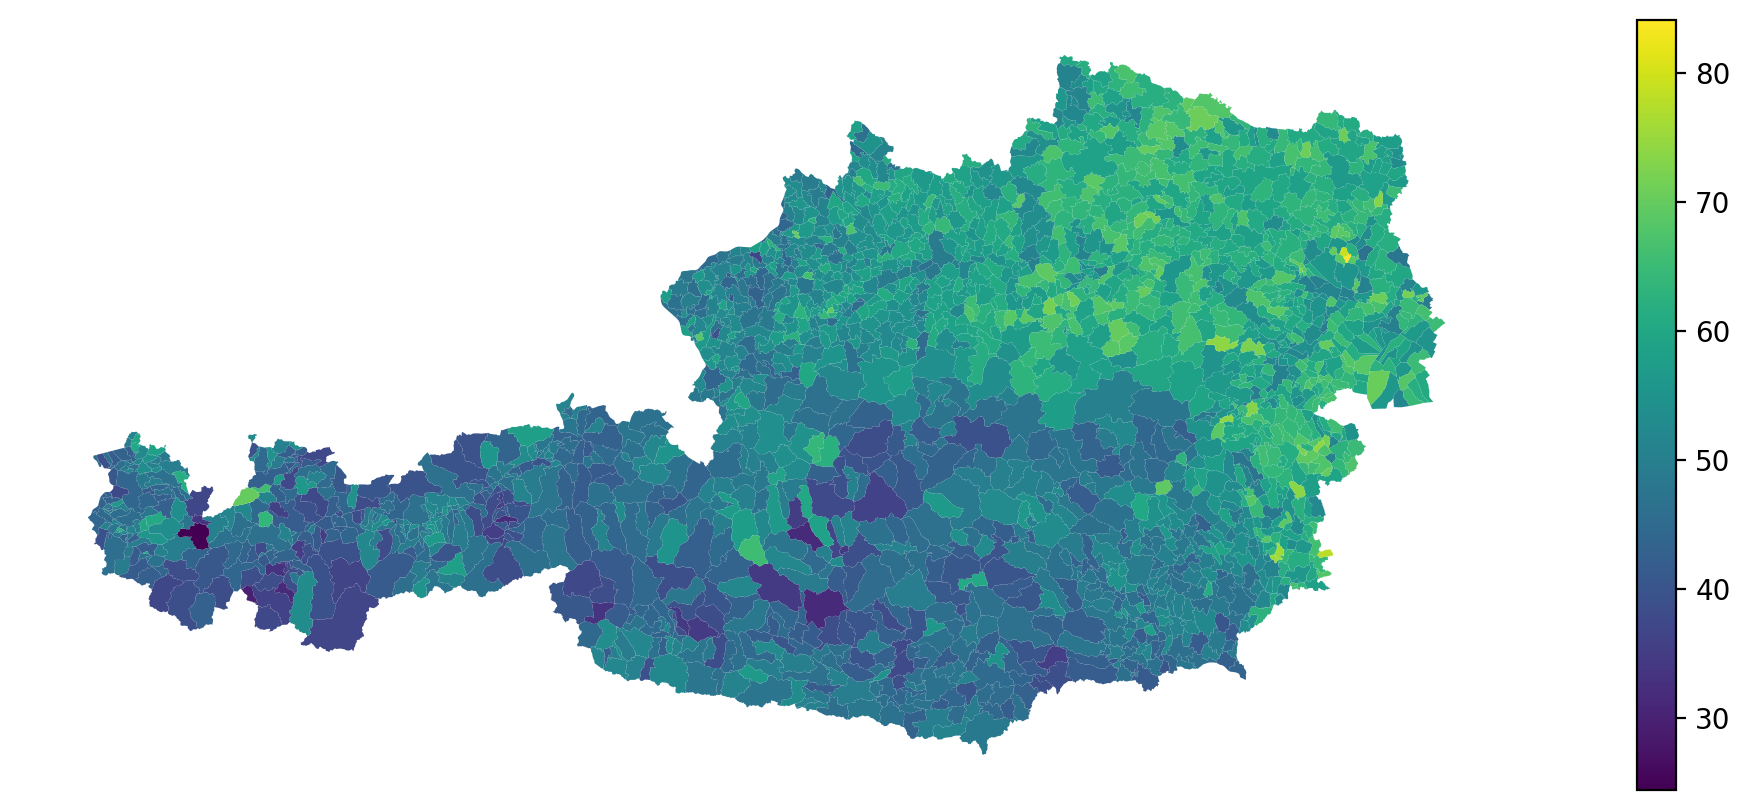

In [46]:
ax = geo.plot(figsize=(16, 5), column='turnout', legend=True);
fig = ax.get_figure()
fig.set_facecolor('#ffffff')
ax.set_axis_off()
fig.savefig('../../reports/aut_choropleth.png')